<big>For classical machine learning algorithms, we often use the most popular Python library, Scikit-learn. With Scikit-learn you can fit models and search for optimal parameters, but it sometimes works for hours.</big><br><br>

<big>I want to show you how to use Scikit-learn library and get the results faster without changing the code. To do this, we will make use of another Python library, <strong> <a href='https://github.com/intel/scikit-learn-intelex'>Intel® Extension for Scikit-learn*</a></strong>.</big><br><br>

<big>I will show you how to <strong>speed up your kernel in 4 times</strong> without changing your code!</big><big>

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing data

In [ ]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
sample_submission = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
pseudo = pd.read_csv('../input/house-price-prediction/result-with-best.csv')

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
train.shape, test.shape

# Preprocessing

<big><strong>Pseudodating</strong></big><br><br>
<big>I took the previously predicted labels and added them to the test dataset.</big>

In [ ]:
test['SalePrice'] = pseudo['SalePrice']

<big>Let's drod "Id" feature.</big>

In [ ]:
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

<big><strong>Outliers</strong></big><br><br>
<big>Explore outliers.</big>

In [ ]:
sns.pairplot(train[["SalePrice", 'GrLivArea']])

<big>As we can see, two examples have a very large GrLivArea and a too low price. We can delete it.</big>

In [ ]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

<big><strong>Feature engineering</strong></big><br><br>
<big>Combine train and test into one dataset.</big>

In [ ]:
train_number = train.shape[0]
test_number = test.shape[0]
full_data = pd.concat((train, test)).reset_index(drop=True)
y = full_data.SalePrice.values
full_data.drop(['SalePrice'], axis=1, inplace=True)
full_data.shape

<big>Let's look at the number of missing values.</big>

In [ ]:
full_data_na = (full_data.isnull().sum() / len(full_data)) * 100
full_data_na = full_data_na.drop(full_data_na[full_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :full_data_na})
missing_data.head(20)

<big><strong>Filling missing values.</strong></big><br><br>
<big>In order to fill in the missing values we will use "data_description.txt".</big>

<big>The file says that NA means no feature.</big>

In [ ]:
full_data["PoolQC"] = full_data["PoolQC"].fillna("None")
full_data["MiscFeature"] = full_data["MiscFeature"].fillna("None")
full_data["Alley"] = full_data["Alley"].fillna("None")
full_data["Fence"] = full_data["Fence"].fillna("None")
full_data["FireplaceQu"] = full_data["FireplaceQu"].fillna("None")
full_data['MSSubClass'] = full_data['MSSubClass'].fillna("None")
full_data["Functional"] = full_data["Functional"].fillna("Typ")
full_data["MasVnrType"] = full_data["MasVnrType"].fillna("None")
full_data["MasVnrArea"] = full_data["MasVnrArea"].fillna(0)

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    full_data[col] = full_data[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    full_data[col] = full_data[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    full_data[col] = full_data[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    full_data[col] = full_data[col].fillna('None')

<big>LotFrontage: Fill in missing values by the median LotFrontage of the neighborhood.</big>

In [ ]:
full_data["LotFrontage"] = full_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

<big>MSZoning, KitchenQual, Exterior1st, Exterior2nd, SaleType and Electrical: Fill in missing values with most common value.</big>

In [ ]:
full_data['MSZoning'] = full_data['MSZoning'].fillna(full_data['MSZoning'].mode()[0])
full_data['Electrical'] = full_data['Electrical'].fillna(full_data['Electrical'].mode()[0])
full_data['KitchenQual'] = full_data['KitchenQual'].fillna(full_data['KitchenQual'].mode()[0])
full_data['Exterior1st'] = full_data['Exterior1st'].fillna(full_data['Exterior1st'].mode()[0])
full_data['Exterior2nd'] = full_data['Exterior2nd'].fillna(full_data['Exterior2nd'].mode()[0])
full_data['SaleType'] = full_data['SaleType'].fillna(full_data['SaleType'].mode()[0])

<big>Delete Utilities feature because it's useless.</big>

In [ ]:
full_data = full_data.drop(['Utilities'], axis=1)

<big>Transforming some numerical variables that are really categorical</big>

In [ ]:
full_data['MSSubClass'] = full_data['MSSubClass'].apply(str)

full_data['OverallCond'] = full_data['OverallCond'].astype(str)

full_data['YrSold'] = full_data['YrSold'].astype(str)
full_data['MoSold'] = full_data['MoSold'].astype(str)

<big><strong>Label encoding.</strong></big>

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
    enc = LabelEncoder() 
    enc.fit(list(full_data[c].values)) 
    full_data[c] = enc.transform(list(full_data[c].values))

<big>Let's add a feature with a total area.</big>

In [ ]:
full_data['TotalSF'] = full_data['TotalBsmtSF'] + full_data['1stFlrSF'] + full_data['2ndFlrSF']

<big>Getting dummy features.</big>

In [ ]:
full_data = pd.get_dummies(full_data)

In [ ]:
full_data.shape

In [ ]:
test = full_data[train_number:]

# Installing Intel(R) Extension for Scikit-learn

<big>Use Intel® Extension for Scikit-learn* for fast compute Scikit-learn estimators.</big>

In [ ]:
!pip install scikit-learn-intelex -q --progress-bar off

<big>Patch original scikit-learn.</big>

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

# Split data into train and test sets

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(full_data, y, test_size = 0.1, random_state=0)

<big>Let's normalize data</big>

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler_x = MinMaxScaler()
scaler_y = StandardScaler()

In [ ]:
scaler_x.fit(x_train)
x_train = scaler_x.transform(x_train)
x_val = scaler_x.transform(x_val)
test = scaler_x.transform(test)

In [ ]:
scaler_y.fit(y_train.reshape(-1, 1))
y_train = scaler_y.transform(y_train.reshape(-1, 1)).ravel()
y_val = scaler_y.transform(y_val.reshape(-1, 1)).ravel()

# Using optuna to select parameters for nuSVR
<big>Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection. The advantage of support vector machines is effective in high dimensional spaces.</big><br>

<big>NuSVR similar to SVR, but uses a parameter nu to control the number of support vectors. Nu replaces the parameter epsilon of epsilon-SVR</big><br><br>
<big>We adjust hyperparameters for the best result.</big><br><br>
<big>Parameters that we select:</big><br>
<big>* <code>C</code> -  Parameter inverse to the regularization coefficient<br></big>
<big>* <code>nu</code> -  An upper bound on the fraction of training errors and a lower bound of the fraction of support vectors.<br></big><br>

In [ ]:
from sklearn.svm import NuSVR
from sklearn.metrics import mean_squared_error
import optuna

In [ ]:
def objective_svr(trial):
    params ={
        'C': trial.suggest_float('C', 0.0001, 5.0),
        'nu':  trial.suggest_float('nu', 0.0, 1.0),
    }
    model = NuSVR(**params).fit(x_train, y_train)
    y_pred = model.predict(x_val)
    loss = np.sqrt(mean_squared_error(y_val, y_pred))
    return loss

<big><strong>Select parameters</strong></big>

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=123),
                            direction="minimize",
                            pruner=optuna.pruners.HyperbandPruner())

<big>Let's see the execution time.</big>

In [ ]:
%%time
study.optimize(objective_svr, n_trials=250)

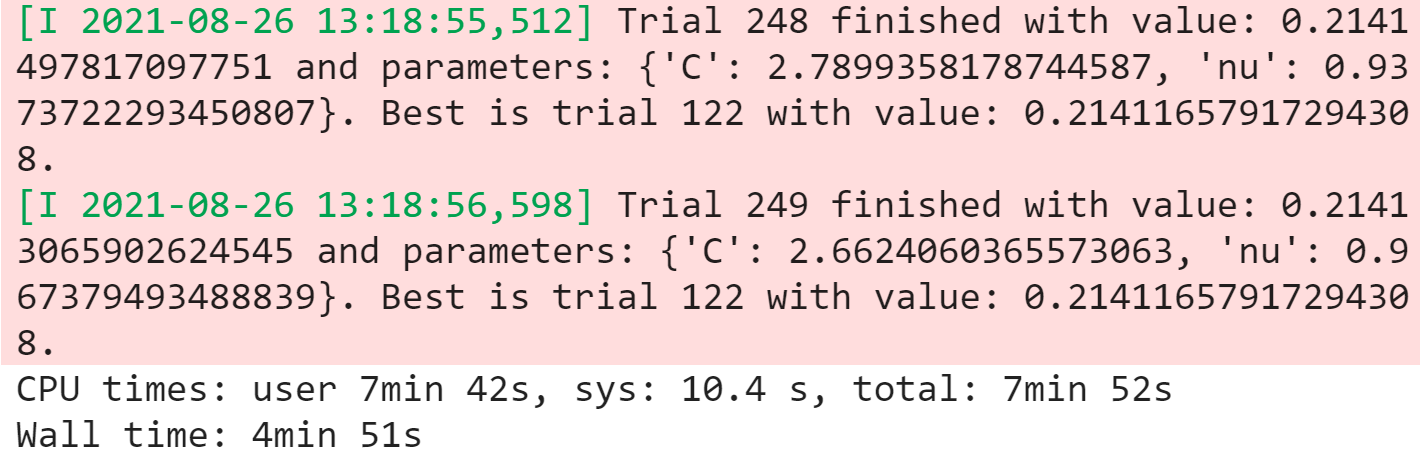
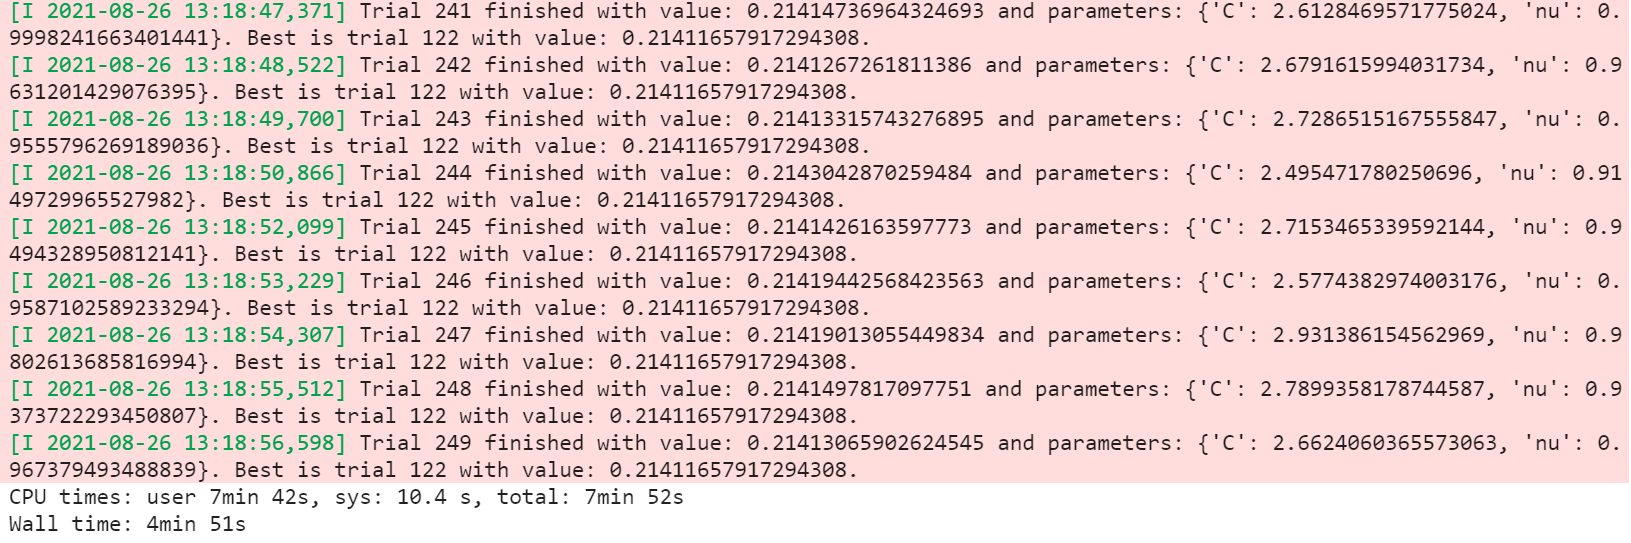

# Training the model with the selected parameters

In [ ]:
full_x = np.concatenate((x_train, x_val), axis=0)
full_y = np.concatenate((y_train, y_val), axis=0)

In [ ]:
%%time
final_model = NuSVR(**study.best_params).fit(full_x, full_y)

# Prediction

In [ ]:
y_pred = final_model.predict(test)
y_pred = scaler_y.inverse_transform(y_pred)

<big>Save the results in 'submission.csv'.</big>

In [ ]:
sample_submission['SalePrice'] = y_pred
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

# Now we use the same algorithms with original scikit-learn
<big>Let’s run the same code with original scikit-learn and compare its execution time with the execution time of the patched by Intel(R) Extension for Scikit-learn.</big>

In [ ]:
from sklearnex import unpatch_sklearn
unpatch_sklearn()

In [ ]:
from sklearn.svm import NuSVR

<big>Select parameters.</big>

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=123),
                            direction="minimize",
                            pruner=optuna.pruners.HyperbandPruner())

<big>Let's see the execution time without patch.</big>

In [ ]:
%%time
study.optimize(objective_svr, n_trials=250)

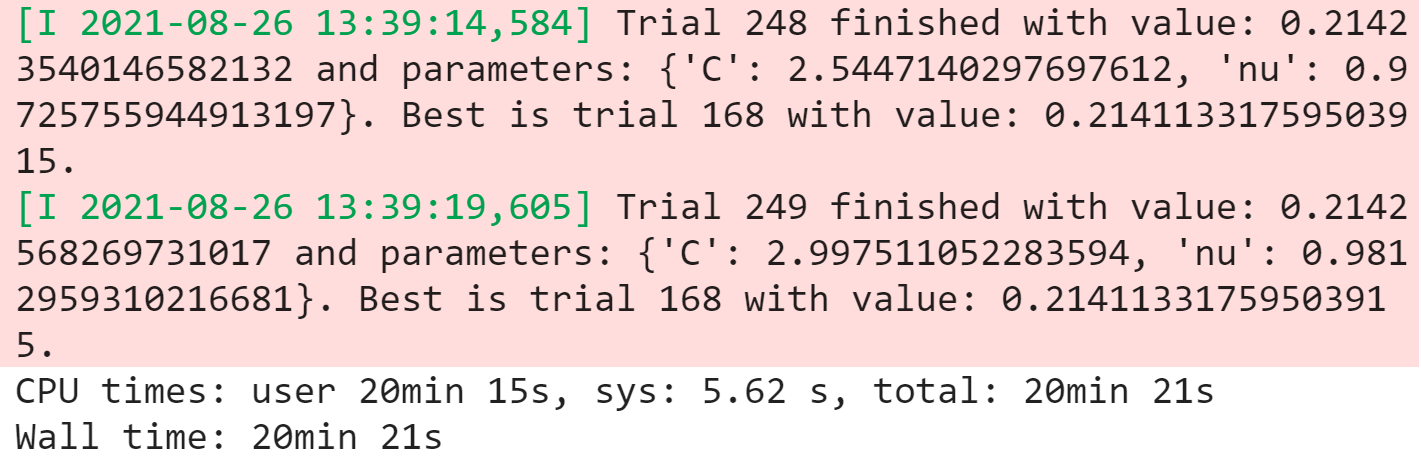
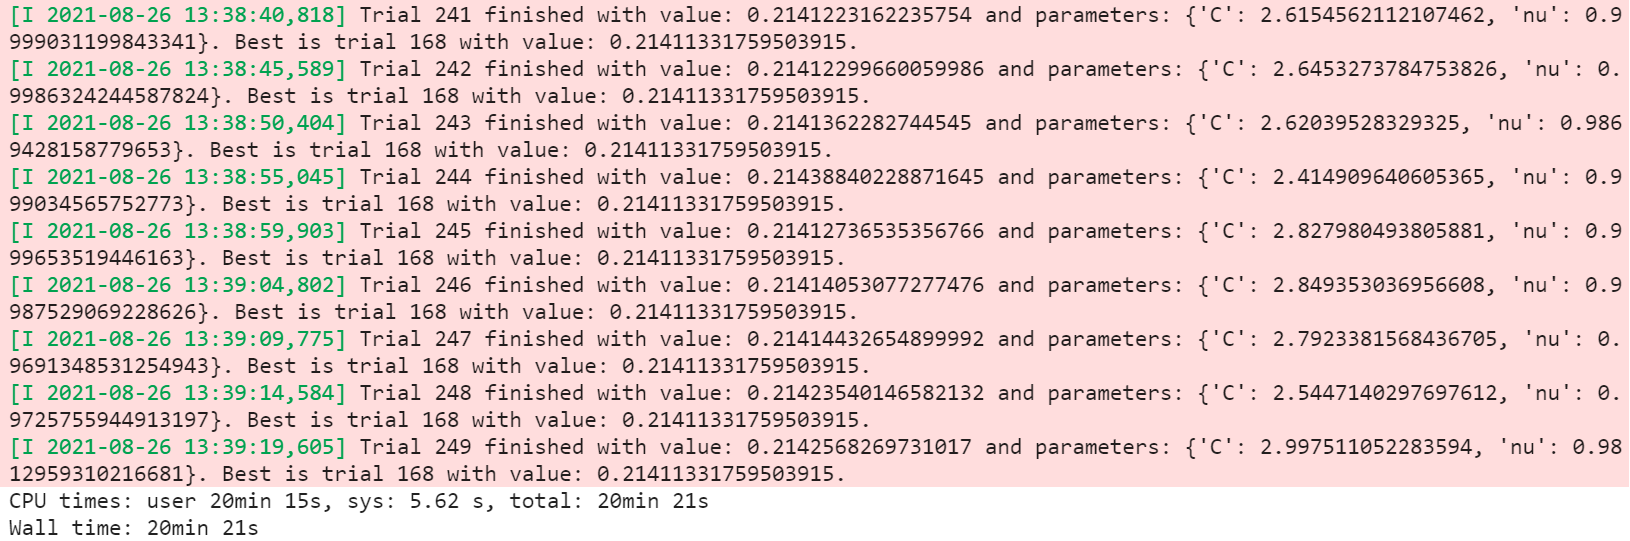

In [ ]:
%%time
final_model = NuSVR(**study.best_params).fit(full_x, full_y)

<h2>Conclusions</h2>
<big>We can see that using only one classical machine learning algorithm may give you a pretty hight accuracy score. We also use well-known libraries Scikit-learn and Optuna, as well as the increasingly popular library Intel® Extension for Scikit-learn. Noted that Intel® Extension for Scikit-learn gives you opportunities to:</big>

* <big>Use your Scikit-learn code for training and inference without modification.</big>
* <big>Speed up selection of parameters <strong>from 20 minutes to 5 minutes.</strong></big>
* <big>Get predictions of the similar quality.</big>
